# Momentum
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie

Notebook released under the Creative Commons Attribution 4.0 License.

---
Momentum trading refers to a general class of strategies which extrapolate from existing trends. They assume that stocks which are going up will continue to go up and stocks which are going down will continue going down, and buy and sell accordingly. This is in contrast to mean-reversion strategies, which rely on trends reversing direction.

For instance, below we see the price of an asset fluctuating but overall going up.

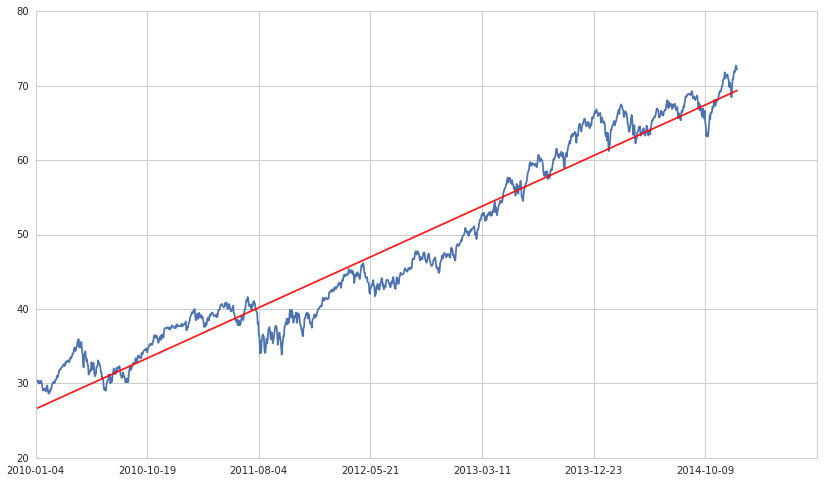

In [134]:
# Import libraries to find linear trend and plot data
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load pricing data for an asset
start = '2010-01-01'
end = '2015-01-01'
asset = get_pricing('XLY', fields='price', start_date=start, end_date=end)
dates = asset.index

# Plot the price of the asset over time
_, ax = plt.subplots()
ax.plot(asset)
ticks = ax.get_xticks()
ax.set_xticklabels([dates[i].date() for i in ticks[:-1]]) # Label x-axis with dates

# Find the line of best fit to illustrate the trend
X = np.arange(len(asset))
x = sm.add_constant(X) # Add a column of ones so that line can have a y-intercept
model = regression.linear_model.OLS(asset, x).fit()
a = model.params[0] # Get coefficients of line
b = model.params[1]
Y_hat = X * b + a
plt.plot(X, Y_hat, 'r', alpha=0.9);

A very simple momentum strategy rebalences its portfolio every period to go long the highest-return asset from a basket and short the lowest-return asset. First, we load the stocks in our basket.

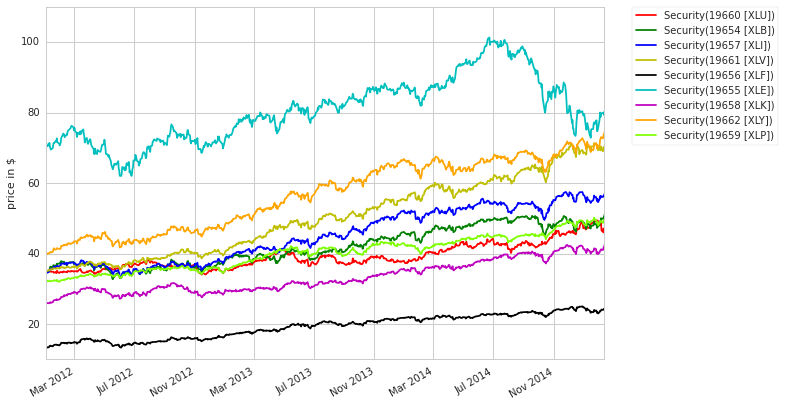

In [135]:
# Load pricing data for some ETFs
assets = ['XLU', 'XLB', 'XLI', 'XLV', 'XLF', 'XLE', 'XLK', 'XLY', 'XLP']
data = get_pricing(assets, start_date='2012-01-04', end_date='2015-02-12')
# Plot the prices over time
data.loc['price', :, :].plot(figsize=(10,7), colors=['r', 'g', 'b', 'y', 'k', 'c', 'm', 'orange',
                                                     'chartreuse', 'slateblue'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('price in $');

We can use `zipline` to simulate our trading strategy. Every 30 days, it buys long the stock with the highest return over the last 90 days, and sells short the one with the lowest return.

[2015-06-22 18:30:54.182281] INFO: Performance: Simulated 782 trading days out of 782.
[2015-06-22 18:30:54.182921] INFO: Performance: first open: 2012-01-04 14:31:00+00:00
[2015-06-22 18:30:54.183353] INFO: Performance: last close: 2015-02-12 21:00:00+00:00


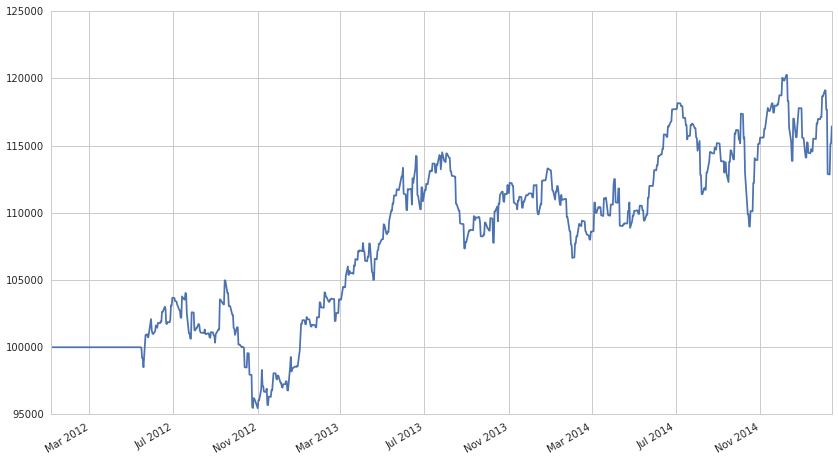

In [136]:
# Import the zipline functions we'll need
import zipline
from zipline.api import (add_history, 
                         symbols,
                         history, 
                         set_slippage, 
                         slippage,
                         set_commission, 
                         commission, 
                         order_target_percent)

from zipline import TradingAlgorithm

# Called at the beginning of the backtest
def initialize(context):
    # Register history container to keep a window of the last 90 days of prices.
    add_history(90, '1d', 'price')
    # Turn off the slippage model
    set_slippage(slippage.FixedSlippage(spread=0.0))
    # Set the commission model (Interactive Brokers Commission)
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
    context.tick = 0
    
def handle_data(context, data):
    # Allow history to accumulate 90 days of prices before trading
    # and rebalance every 30 days thereafter.
    context.tick += 1
    if context.tick < 90 or not context.tick % 30:
        return
    # Get rolling window of past prices
    prices = history(90, '1d', 'price').dropna()
    stocks = prices.columns

    # Find the top- and bottom-performing stocks from the last period
    top_stock = ['', 0]
    bottom_stock = ['', 0]
    for stock in stocks:
        p1 = prices[stock].ix[-1]
        p0 = prices[stock].ix[0]
        pct_change = (p1 - p0)/p0
        if pct_change > top_stock[1]:
            top_stock = [stock, pct_change]
        elif pct_change < bottom_stock[1]:
            top_stock = [stock, pct_change]
    # Number of positions we'll hold: if no stock with returns > 0 was found, there will be no top stock,
    # and vice versa for bottom
    n = bool(top_stock[0]) + bool(bottom_stock[0])
    
    # Clear portfolio of current positions, then buy top stock and sell bottom stock
    for stock in context.portfolio.positions:
        order_target_percent(stock, 0)
    if top_stock[0]:
        order_target_percent(top_stock[0], 1.0/n) # 50% if there is a bottom stock, 100% otherwise
    if bottom_stock[0]:
        order_target_percent(bottom_stock[0], -1.0/n)
        
# Instantinate algorithm        
algo = TradingAlgorithm(initialize=initialize, handle_data=handle_data)
# Run algorithm
results = algo.run(data.swapaxes(2, 0, 1))
results.portfolio_value.plot();

The performance of this portfolio is plotted above.

A more complex momentum strategy might use hedging, diversification, or information from other signals to lower risk. Also, the window over which the returns are computed and the frequency of rebalancing drastically affect performance, so their selection is an important part of the strategy.